In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

# Modèle boite noire 02

### Chargement des données

In [101]:
df_full  = pd.read_pickle( 'weatherdata.pck' )

In [108]:
df = df_full[['T_int', 'temperature', 'flux_tot', 'windSpeed']].copy()

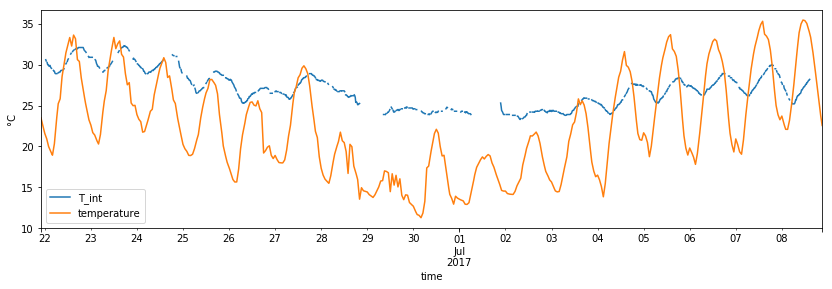

In [109]:
df[['T_int', 'temperature']].plot( figsize=(14, 4) ); plt.ylabel('°C');

# Le modèle
![schéma eq.](images/sch_blackbox02.png)

$$
 \frac{dT}{dt} = \frac{h}{M} \,\left[ T_{ext}(t) - T \right] + \frac{\eta}{M} \, \Phi(t)
$$



Il y a deux paramètres, tous les deux normés par la masse thermique $M$:  
 * $\eta / M$ qui correspond à l'absorption des rayon solaire, normalement entre 0 et 1.
 * $h / M$ qui correspond à l'isolation avec l'air extérieur.

### Solveur Ode

In [47]:
from scipy.integrate import odeint

In [115]:
def get_dTdt(  T, t, params, get_Text, get_Phi ):
    """ dérivé de la température p/r au temps
        params :   [ h/M  ,  eta/M ]
        get_Text, get_Phi: fonction d'interpolation 
    """
    
    T_ext  = get_Text( t )
    phi = get_Phi( t ) 
    
    dTdt = params[0] * ( T_ext - T ) + params[1] / 100 * phi
    
    return 1e-6*dTdt


def apply_model( data, T_start, params, full_output=False ):

    data_dict = data.to_dict(orient='list')
    time_sec = data.index.astype(np.int64) // 10e9    # conversion en secondes

    # construction des fonctions d'interpolations: 
    get_Text = lambda t: np.interp( t, time_sec, data_dict['temperature'] )
    get_Phi  = lambda t: np.interp( t, time_sec, data_dict['flux_tot'] )

    T_theo = odeint(get_dTdt, T_start, time_sec, args=(params, get_Text, get_Phi  ), \
                full_output=full_output, h0=30*60)
    # h0 : pas de temps initial utilisé par le solveur
    
    return T_theo.flatten()

**Rq:** Facteur _100_ et _1e-6_ pour avoir des valeurs proches de l'unité

### Test sur les données entières :

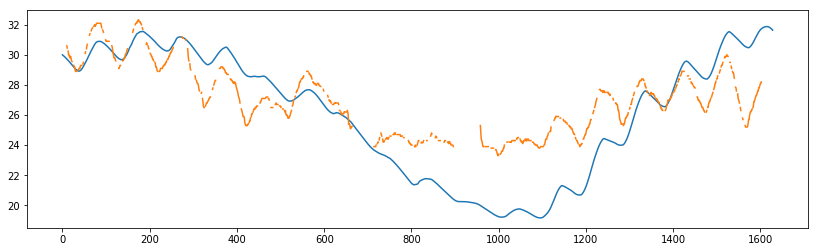

In [127]:
params =  ( 40, 80)

res = apply_model( df, 30, params )

plt.figure( figsize=(14, 4) )
plt.plot( res )
plt.plot( df['T_int'].as_matrix() ) ;

Les paramètres $\eta$ et $h$ correspondent principalement à l'ouverture des fenêtres et aux volets sur celle-ci. Ils sont donc dépendant de la période de la journée, et de la météo. L'idée est d'estimer jour par jour leurs valeurs. 

mais :
* la nuit, $\Phi = 0$ donc $\eta$ est non déterminé
* le jour, $T_{ext}(t)$ est fortement corrélé avec $\Phi(t)$. Découpler les deux paramètres est alors pas évident. 

Les estimations sont donc effectuées séparement : le jour pour $\eta$ (avec un $h$ résiduel), et la nuit pour $h$ (correspondant à la ventilation).

# Estimation jour par jour

In [214]:
from scipy.optimize import minimize
from scipy.optimize import fmin

def get_errorfit( params, data, T_start    ):

    T_exp = data['T_int'].as_matrix()
    T_theo = apply_model( data, T_start, params )
    
    delta = (T_exp - T_theo)**2
    return np.sum( delta[  ~np.isnan( delta ) ] )
  

In [215]:
"""  on distingue le fit suivant la nuit ou le jour
        pour ne fitter qu'un seul paramètre
"""
from scipy.optimize import fminbound


def fit_model_p1( data, T_start, param_0  ):
    func0 = lambda x: get_errorfit( (param_0, x), data, T_start  )
    x1, x2 = (.1, 1000)
    param_1 = fminbound(func0, x1, x2, disp=0)
    #param_1 = fmin(func0, 20)

    return param_1

def fit_model_p0( data, T_start, param_1 ):
    func1 = lambda x: get_errorfit( (x, param_1), data, T_start  )
    x1, x2 = (.1, 1000)
    param_0 = fminbound(func1, x1, x2, disp=0)
    #param_0 = fmin(func1, 20)
    
    return param_0

### Groupy by night/day

In [216]:
df['isnight'] = ( df['flux_tot'] == 0 ).astype(int)

nights_days = df['isnight'].diff().abs().cumsum()
nights_days[0] = 0

df_byday  = df.groupby(nights_days) 

Groupes = [ int( k ) for k in df_byday.groups.keys() ]

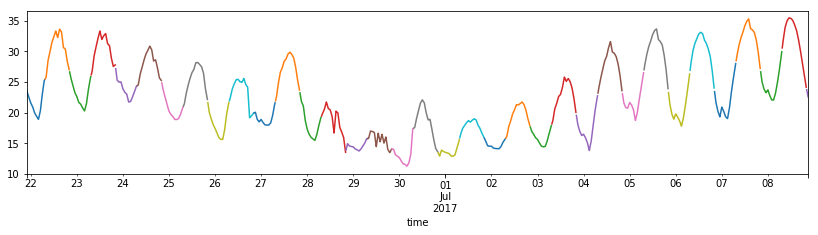

In [220]:
df_byday['temperature'].plot( figsize=(14, 3) );

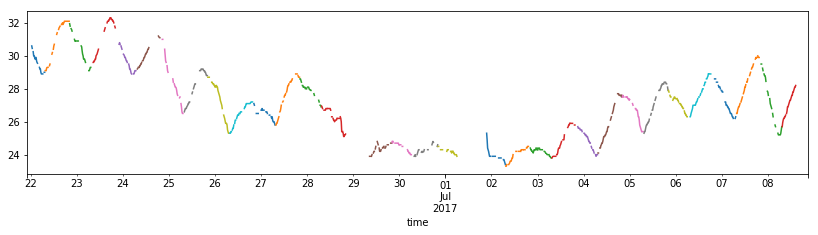

In [221]:
df_byday['T_int'].plot( figsize=(14, 3) );

### Fit group by group

In [222]:
def fit_a_day( data, T_zero ):
    
    T_exp = data['T_int'].as_matrix()
    nombre_nonNaN = T_exp.size - np.isnan( T_exp ).sum()
    if nombre_nonNaN < 10:
        # pas assez de donnée pour faire le fit
        h, eta = np.nan, np.nan
        res = np.full( T_exp.shape , np.nan)
        
    else:
        eta_night = 0
        h_day = 20   # résiduel ... comment distinguer phi / T_ext en journée ?

        if  data['isnight'].all():
            h = fit_model_p0( data, T_zero, eta_night )
            eta = eta_night
        else:
            h = h_day
            eta = fit_model_p1( data, T_zero, h_day )

        res = apply_model( data, T_zero, (h, eta) )
    
    return (h, eta), res

### For one day

2017-06-26 07:30:00
(20, 302.25954197040903)


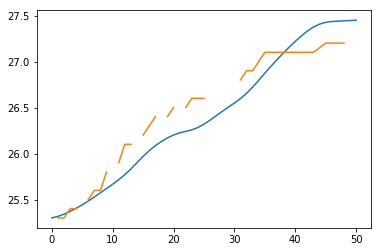

In [223]:
data = df_byday.get_group(  Groupes[9] )

T_int = data['T_int'].as_matrix()
T_zero = T_int[ ~ np.isnan( T_int ) ][0]

params, res = fit_a_day( data, T_zero )

print( data.index[0] )
print( params )

plt.plot( res )
plt.plot( T_int );

### Loop

In [224]:
# init
df['T_theo'] = 0
df['eta_M'], df['h_M'] = 0, 0

# valeur initiale
T_zero = df['T_int'][ df['T_int'].first_valid_index() ]

for grp_id in Groupes:
    print( '%i, ' % grp_id, end='' )
    data_day = df_byday.get_group(  grp_id ) 
    
    if np.isnan( T_zero ):
        T_zero = data_day['T_int'][ data_day['T_int'].first_valid_index() ]
    
    # fit
    params, res = fit_a_day( data_day, T_zero )
    
    # save
    df.loc[ data_day.index, 'T_theo'] =  res
    df.loc[ data_day.index, 'eta_M'] =  params[1]
    df.loc[ data_day.index, 'h_M'] =  params[0]

    # valeur initiale pour l'étape suivante
    T_zero = res[-1]

    
print('done')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, done


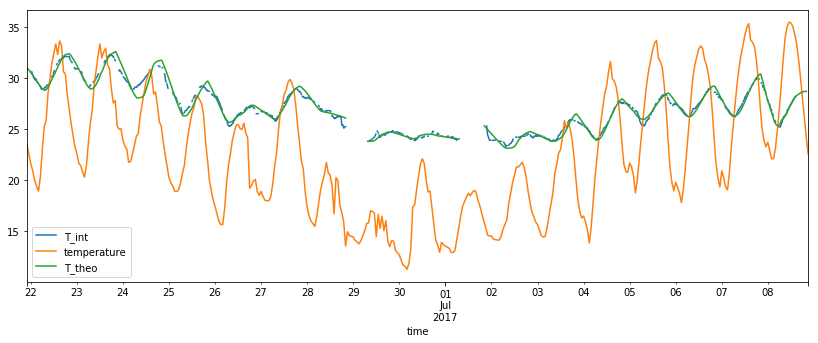

In [225]:
df[['T_int', 'temperature', 'T_theo']].plot( figsize=(14, 5)  ); 

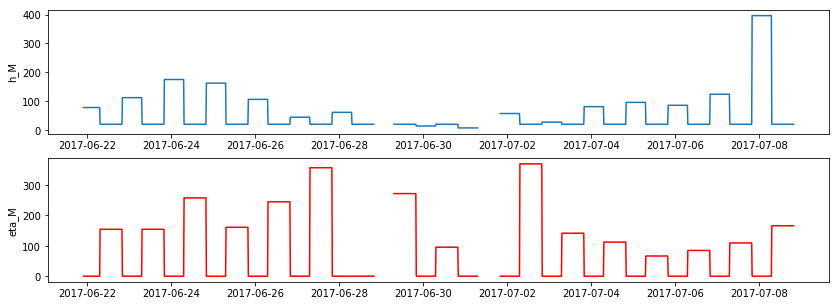

In [212]:
plt.figure( figsize=(14, 5) )
plt.subplot( 2, 1, 1 )
plt.plot( df[['h_M']] ); plt.ylabel('h_M');

plt.subplot( 2, 1, 2 )
plt.plot( df[['eta_M']], 'r' ); plt.ylabel('eta_M');

### Ordres de grandeurs 
eta : pourcentage entre 0 et 100  
h : 10 - 600 W/K  

M ~  10e6 J/K    ( 8cm de béton sur 50m2 )